# Classification Tests

spiegazione test

### Imports

In [ ]:
import re
import xml.etree.ElementTree as ET
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import it_core_news_sm
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
import collections
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
# Skopt functions
from sklearn.metrics import make_scorer, f1_score, recall_score
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from skopt import gp_minimize # Bayesian optimization using Gaussian Processes
from skopt.space import Real, Categorical, Integer
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import math
import scipy.stats
import sys
from info_gain import info_gain

In [ ]:
#nltk.download('punkt')

## Classes

In [ ]:
class CarWordsHandler:
    # https://github.com/n8barr/automotive-model-year-data
    def __init__(self, cars_file):
        self.brands_list = set()
        self.models_list = set()
        f = open(cars_file, "r")
        cars_list = f.read().splitlines()
        for i in range(len(cars_list)):
            brand = cars_list[i].split(',')[0][1:].lower()
            model = cars_list[i].split(',')[1][0:-1].lower()
            self.brands_list.add(brand)
            self.models_list.add(model)
        # remove some useless models
        self.models_list.remove('i')
        #self.models_list.remove('gli')
        #self.models_list.remove('estate')
        self.brands_list = list(self.brands_list)
        self.models_list = list(self.models_list)
        self.brands_list.sort()
        self.models_list.sort()
    
    # binary search to get if a word is a brand 
    def isBrand(self, word):
        word = word.lower()
        first = 0
        last = len(self.brands_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.brands_list[mid]:
                return True
            elif word < self.brands_list[mid]:
                last = mid
            elif word > self.brands_list[mid]:
                first = mid
            if last-first == 1:
                if self.brands_list[first] == word or self.brands_list[last] == word:
                    return True
                else:
                    return False
    # binary search to get if a word is a brand 
    def isModel(self, word):
        word = word.lower()
        first = 0
        last = len(self.models_list) -1
        while first < last:
            mid = int((last + first) / 2)
            if word == self.models_list[mid]:
                return True
            elif word < self.models_list[mid]:
                last = mid
            elif word > self.models_list[mid]:
                first = mid
            if last-first == 1:
                if self.models_list[first] == word or self.models_list[last] == word:
                    return True
                else:
                    return False

In [ ]:
a = CarWordsHandler('resources/cars.txt')
a.models_list
a.isModel('e 110')

## Functions

In [ ]:
# encoding issues
def correctEncodings(comment):
    fin_comment = comment
    fin_comment = re.sub('Ã¨', 'è', fin_comment)
    fin_comment = re.sub('Ã©', 'é', fin_comment)
    fin_comment = re.sub('Ã¬', 'ì', fin_comment)
    fin_comment = re.sub('Ã²', 'ò', fin_comment)
    fin_comment = re.sub('Ã¹', 'ù', fin_comment)
    fin_comment = re.sub('Ã', 'à', fin_comment)
    return fin_comment
# tokenize function
def tokenize(text):
    tokens = nltk.word_tokenize(text, 'italian')
    italian_stopwords = stopwords.words('italian')
    return [token for token in tokens if not token in italian_stopwords]
# recognize an URL
def isURL(word):
    # http://forum.rusconi.it/gentemotori/viewtopic.php ? t=434&sid=57c88f1b507d8f57717ea18e74e25324Â 
    return len(re.findall("^((http(s){0,1}://)|(www.))\S+$", word)) > 0
# recognize an image tag
def isPicture(word):
    return len(re.findall("^<img.*>$", word)) > 0
# remove punctation
def removePunctation(comment):
    return re.sub(r'\s{2,}', ' ', str(re.sub(r'[\'\"\,\.,\:\-]', ' ', comment)))
# fix issues on urls
def replaceURLs(comment):
    return str(re.sub(r'(http(s){0,1}://|www.)(([^\s]+)|/)+((\s\?\s)[^\s]+){0,1}', 'URL', comment)).replace(u'\xa0', u' ')
# replace images
def replaceIMGs(comment):
    return str(re.sub(r'<img.+>', 'IMG', comment))
# replace brands
def replaceBrands(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isBrand(tokens[i]):
            tokens[i] = 'BRAND'
    return ' '.join(tokens)
# replace models
def replaceModels(cwhandler, comment):
    tokens = tokenize(comment)
    for i in range(len(tokens)):
        if cwhandler.isModel(tokens[i]):
            tokens[i] = 'MODEL'
    return ' '.join(tokens)
# replace question marks
def replaceQMarks(comment):
    comment = re.sub(r'\?{2,}', ' MULTI_QMARK', comment)
    comment = re.sub(r'\?', ' QMARK', comment)
    return comment
# replace esclamation marks
def replaceEMarks(comment):
    comment = re.sub(r'\!{2,}', ' MULTI_EMARK', comment)
    comment = re.sub(r'\!', ' EMARK', comment)
    return comment
# remove character repetitions
def removeRepeat(comment):
    return re.sub(r'(a-zA-Z)\1{2,}', r'\1\1\1', comment)
# replace speed
def replaceSpeed(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/h|mph|kmh)', 'SPEED', comment)
# replace consumption
def replaceConsumption(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km\/l|mpg)', 'CONSUMPTION', comment)
# replace weight
def replaceWeight(comment):
    return re.sub(r'[0-9\.*]+(\s*)(kg|tonnellate|ton|chili|kili)', 'WEIGHT', comment)
# replace power + torque
def replacePower(comment):
    return re.sub(r'[0-9]+\s*(cv|nm|kw)', 'POWER', comment)
# replace distance
def replaceDistance(comment):
    return re.sub(r'([0-9\.*]+(\s*(\-|\/|\s)\s*)+){0,1}[0-9\.*]+(\s*)(km|miles|kilometri|chilometri)', 'DISTANCE', comment)
# replace numbers
def replaceNumbers(comment):
    return re.sub(r'[0-9]{3,}', 'NUMBER', comment)


Sentiment http://valeriobasile.github.io/twita/sentix.html

In [6]:
class ItalianWordsHandler:
    # https://dspace-clarin-it.ilc.cnr.it/repository/xmlui/handle/20.500.11752/ILC-73
    def __init__(self, words_file):
        # words information
        self.words_dict = dict()
        root = ET.parse(words_file).getroot()
        for entry in root.findall('Lexicon/LexicalEntry'):
            word = entry.find('Lemma').get('writtenForm')
            pos = entry.get('partOfSpeech')
            senti = entry.find('Sense/Sentiment').get('polarity')
            conf = entry.find('Sense/Confidence').get('score')
            self.words_dict[word] = {'POS': pos, 'Sentiment': senti, 'Confidence': conf}
        # stemmer
        self.it_stem = nltk.stem.SnowballStemmer("italian", ignore_stopwords=True)
        
    # get word info. None if not exists
    def getWordInfo(self, word):
        # fields: POS, Sentiment, Confidence
        return self.words_dict.get(word)
    
    # italian stemmer http://snowball.tartarus.org/algorithms/italian/stemmer.html
    def stem(self, comment):
        tokens = tokenize(comment)
        return ' '.join([token if token.isupper() else self.it_stem.stem(token) for token in tokens])
    
    # correct words
    def correctWords(self, text):
        # not yet implemented
        return text

In [7]:
class Preprocessor:
    
    def __init__(self):
        self.cwh = CarWordsHandler('resources/cars.txt')
        self.iwh = ItalianWordsHandler('resources/ita_opeNER.xml')
        self.pos = it_core_news_sm.load()
    # preprocess text
    # allowed methods: word, swnt, pos
    # ner (named entity recognition), replacing for instance 100 km/h with SPEED
    def preprocessText(self, text, method='word', use_stemmer=False, ner=False):
        if method not in ['word', 'pos', 'swnt']:
            raise ValueError('Method not recognized. Select from word, swnt, pos')
        # correct encodings (not yet implemented)
        fin_text = correctEncodings(text)
        # remove punctation
        fin_text = removePunctation(fin_text)
        # some basic preprocessing
        fin_text = fin_text.lower()
        # correct words (not yet)
        fin_text = self.iwh.correctWords(fin_text)
        # manage repetitions
        fin_text = removeRepeat(fin_text)
        # manage punctation
        fin_text = replaceQMarks(fin_text)
        fin_text = replaceEMarks(fin_text)
        # manage URLs
        fin_text = replaceURLs(fin_text)
        # manage Images
        fin_text = replaceIMGs(fin_text)
        # remove stopwords
        tokens = tokenize(fin_text)
        fin_text = ' '.join(tokens) 
        # NOW DEPENDS ON NER
        if ner:
            # manage brands and models
            fin_text = replaceBrands(self.cwh, fin_text)
            fin_text = replaceModels(self.cwh, fin_text)
            # manage speed consumption and weight
            fin_text = replaceSpeed(fin_text)
            fin_text = replaceConsumption(fin_text)
            fin_text = replaceWeight(fin_text)
            fin_text = replacePower(fin_text)
            fin_text = replaceDistance(fin_text)
            fin_text = replaceNumbers(fin_text)
        # NOW DEPENDS ON METHOD
        if method == 'word':
            # just do nothing except eventually stemming
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'swnt':
            tokens = tokenize(fin_text)
            swnt_tokens = []
            for t in tokens:
                info = self.iwh.getWordInfo(t)
                if info == None or info['Sentiment'] == None:
                    swnt_tokens.append(t)
                else:
                    # confidence 0-100
                    swnt_tokens.append(str(info['Sentiment'])[:3].upper() + '_' + str(int(float(info['Confidence'])*10)))
            fin_text = ' '.join(swnt_tokens)
            # stemmer
            if use_stemmer:
                tokens = tokenize(fin_text)
                fin_text = ' '.join([t if t.isupper() else self.iwh.stem(t) for t in tokens]) 
        elif method == 'pos':
            doc = self.pos(fin_text)
            pos_tokens = []
            # pos
            for t in doc:
                pos_tokens.append(str(t.pos_))
            # pos_word
            for t in doc:
                pos_tokens.append(str(t.pos_) + '_' + str(t))
                    
            fin_text = ' '.join(pos_tokens)
            # stemmer
            if use_stemmer:
                fin_text = self.iwh.stem(fin_text) 
        
        return str(re.sub(r'\s{2,}', ' ', fin_text))

In [8]:
class Vectorizer:
    
    def __init__(self, list_comments, method='bow', max_features=1000, ngrams=2, just_presence=False):
        if method not in ['bow', 'tfidf']:
            raise ValueError('Method not recognized. Select from bow, tfidf')
        if method == 'bow':
            self.vectorizer = CountVectorizer(ngram_range=(1,ngrams), binary=just_presence, lowercase=False, max_features=max_features)
        elif method == 'tfidf':
            self.vectorizer = TfidfVectorizer(ngram_range=(1,ngrams), lowercase=False, max_features=max_features)
        # fit vectorizer
        self.vectorizer.fit(list_comments)          
        
    def vectorize(self, comment):
        return self.vectorizer.transform([comment])
        
    def get_feature_names(self):
        return self.vectorizer.get_feature_names()
    
    def get_num_features(self):
        return len(self.vectorizer.get_feature_names())

Preprocessing Example

In [9]:
text = 'Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. '
print(text)
print('##########################################################################################')
p = Preprocessor()
print(p.preprocessText(text, ner=True, use_stemmer=True, method='word'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=False, method='swnt'))
print('##########################################################################################')
print(p.preprocessText(text, ner=True, use_stemmer=True, method='pos'))


Sono reali calcolati nel arco del tutto anno nel estate qualcosa in piÃ¹ causa gomme di 17" e climatizzatore nel inverno un po di meno. Per quanto riguarda le autostrade quelle che percorro io principalmente la A4 e molto congestionata cosi spesso la media e 110-115 km/h che ovviamente influisce positivamente a i consumi. Ma quello che mi piace di piÃ¹ Ã¨ assenza dei guasti. Sulla vecchia Accord il primo guasto lo ho avuto a 200000 km si Ã¨ rotto il termostato della clima. Ogni tanto faccio giro di altri forum e leggo delle turbine rotte catene di distribuzione progettate male iniettori fatti male mah nel 2015 per me sono le cose incomprensibili . Con tutti gli difetti che puÃ² avere preferisco la Honda. 
##########################################################################################
real calcol arco anno MODEL qualcos caus gomm MODEL climatizz invern po men riguard autostrad percorr principal MODEL molt congestion cos spess med MODEL SPEED ovvi influ posit consum piac assen

For each comment divide Text from Quote by setting _TEXT or _QUOTE at the end of each word. This after preprocessing

In [10]:
def combine_text_quote(text, quote, divide_quote=True):
    text_tokens = tokenize(text)
    quote_tokens = tokenize(quote)
    combined_tokens = []
    for tt in text_tokens:
        if divide_quote:
            combined_tokens.append(str(tt) + '_TEXT')
        else:
            combined_tokens.append(str(tt))
    for qt in quote_tokens:
        if divide_quote:
            combined_tokens.append(str(qt) + '_QUOTE')
        else:
            combined_tokens.append(str(qt))
    return ' '.join(combined_tokens)

In [11]:
print(combine_text_quote('Bene grazie', 'ciao come va', divide_quote=False))

Bene grazie ciao va


# Dataset

In [12]:
column = 'Motore'

In [13]:
original_dataset = pd.read_csv('dataset.csv').fillna('')[['TESTO', '(Testo Citato)', column]]
dataset = original_dataset.copy()
dataset

,TESTO,(Testo Citato),Motore
0,Allora il problema è che non sono aggiornati i...,,irrilevante
1,E' virgolettato appositamente.... E soprattutt...,,irrilevante
2,Mah io sulla mappa ev-way ho visto solo tipo 2...,'Inferiore non s ma probabilmente uguale (il m...,irrilevante
3,Ah però.... uno pensa di averne viste tante su...,Sinceramente una differenza di 9.800? non mi p...,irrilevante
4,Basta darsi delle regole e per questo tipo di ...,,irrilevante
5,Personalmente posso ritenermi un possessore di...,,irrilevante
6,Confermo che il posteriore è riuscitissimo e a...,"""sono stato anch'io in conce per altri motivi ...",irrilevante
7,Mi sa che l'unica cosa apprezzabile del rst è ...,,irrilevante
8,grazie ! ! ! ! !,,irrilevante
9,Cosimo hai centrato completamente,,irrilevante


Preprocessing

In [14]:
pp = Preprocessor()
# TESTO
for i in range(len(dataset)):
    dataset['TESTO'][i] = pp.preprocessText(dataset['TESTO'][i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(len(dataset)):
    dataset['(Testo Citato)'][i] = pp.preprocessText(dataset['(Testo Citato)'][i], method='word', use_stemmer=True, ner=True)    

In [15]:
# combine labels "molto positivo" = "positivo" and so on
dataset[column] = dataset[column].replace('molto positivo', 'positivo')
dataset[column] = dataset[column].replace('molto negativo', 'negativo')

Vectorization

Split into training and test

In [16]:
# numpy_dataset = np.array(preprocessed_dataset)
# print('Length: ' + str(numpy_dataset.shape[0]))

In [17]:
np.random.seed(42)
# split 80% training and 20% test
# FARLO RISPETTANDO LA DISTRIBUZIONE
#perm = np.random.permutation(numpy_dataset.shape[0])
#np.random.shuffle(numpy_dataset)
#numpy_dataset = numpy_dataset[perm]
#split = int(0.8 * numpy_dataset.shape[0])
#train_dataset, test_dataset = numpy_dataset[:split,:], numpy_dataset[split:,:]
train_dataset_X, test_dataset_X, train_dataset_y, test_dataset_y = train_test_split(dataset[['TESTO', '(Testo Citato)']], dataset[column], test_size=0.2, stratify=dataset[column], shuffle=True, random_state=52)
# split validation
train_dataset_X, valid_dataset_X, train_dataset_y, valid_dataset_y = train_test_split(train_dataset_X, train_dataset_y, test_size=0.2, stratify=train_dataset_y, shuffle=True, random_state=52)

In [18]:
train_dataset_X

,TESTO,(Testo Citato)
122,rinasc ver alfa QMARK QMARK QMARK sper viv MOD...,
2675,sol dat MODEL e46 1 03g,gent parl MODEL noi vol smett scann ognun mod ...
575,cap ben discors rod pot aver EMARK,
2274,perch\xe9 lasc benzin ste pov MODEL QMARK rima...,iniett gpl stat liquid
3345,buon MODEL,
4891,ghis ghis modular espression tecnolog italian ...,
4125,ricord MODEL special rally cont quand ancor ra...,rally son ver rischios tanak quand affond lagh...
5717,http //URL net/articol php QMARK a_id=number,
4675,cia vogl vend ns BRAND MODEL immatricol 11/NUM...,codic mic compr km zer QMARK s infatt mogl com...
2708,madonn segh mental travers fat EMARK stat ved ...,


Some statistics

In [19]:
collections.Counter(valid_dataset_y)

Counter({'irrilevante': 1017, 'neutro': 57, 'negativo': 25, 'positivo': 51})

In [20]:
train_concat = []
for i in range(len(train_dataset_X)):
    train_concat.append(combine_text_quote(train_dataset_X['TESTO'].iloc[i], train_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat = []
for i in range(len(valid_dataset_X)):
    valid_concat.append(combine_text_quote(valid_dataset_X['TESTO'].iloc[i], valid_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat = []
for i in range(len(test_dataset_X)):
    test_concat.append(combine_text_quote(test_dataset_X['TESTO'].iloc[i], test_dataset_X['(Testo Citato)'].iloc[i], divide_quote=False))

In [21]:
# access a validation entry
# valid_concat[0]
# valid_dataset_X['TESTO'].loc[2575]

Finally replace text with vector, and replace label with numerical representation

In [22]:
# VECTORIZE
vec = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X = vec.fit_transform(train_concat)
train_y = np.empty([len(train_concat), 1]).ravel()
valid_X = vec.transform(valid_concat)
valid_y = np.empty([len(valid_concat), 1]).ravel()
# training
train_y = train_dataset_y.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)
# validation
valid_y = valid_dataset_y.replace('irrilevante',  0).replace('positivo', 1).replace('neutro', 1).replace('negativo', 1)

In [23]:
train_X

<4596x156369 sparse matrix of type '<class 'numpy.float64'>'
	with 348192 stored elements in Compressed Sparse Row format>

## SVM _TFIDF Classifier

https://towardsdatascience.com/automated-machine-learning-hyperparameter-tuning-in-python-dfda59b72f8a

First tests for feature selection

In [24]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(svm_clf, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf.fit(train_X, train_y)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


[LibSVM]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.259 (+/-0.131) for {'C': 1.0}
0.363 (+/-0.154) for {'C': 10.0}
0.357 (+/-0.145) for {'C': 100.0}
0.367 (+/-0.161) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [25]:
# predictions
pred_y = clf.best_estimator_.predict(valid_X)

F1 score on validation data: 0.5634920634920635
Recall on validation data: 0.5338345864661654
Precision on validation data: 0.5966386554621849


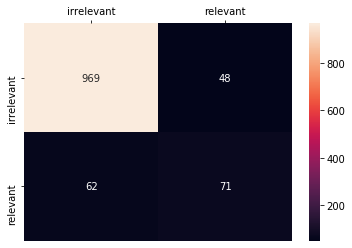

In [26]:
# 0=irrilevante, 1=rilevante
print('F1 score on validation data: ' + str(f1_score(valid_y, pred_y, average='binary')))
print('Recall on validation data: ' + str(recall_score(valid_y, pred_y)))
print('Precision on validation data: ' + str(precision_score(valid_y, pred_y)))
cm = confusion_matrix(valid_y, pred_y, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight

The weight/coefficient matrix of a generalised linear model predictor, of shape (n_features,) for binary classification and single-output regression, (n_classes, n_features) for multiclass classification and (n_targets, n_features) for multi-output regression. Note this does not include the intercept (or bias) term, which is stored in intercept_.

When available, feature_importances_ is not usually provided as well, but can be calculated as the norm of each feature’s entry in coef_.

https://stats.stackexchange.com/questions/39243/how-does-one-interpret-svm-feature-weights

In [27]:
weights = clf.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 156369)


In [28]:
print(weights.indices)
print(weights.data)

[153825 153429 148803 ...   3786   3174   3171]
[ 0.24463757  0.24463757  0.24463757 ... -0.58612477 -0.49625109
  0.06453074]


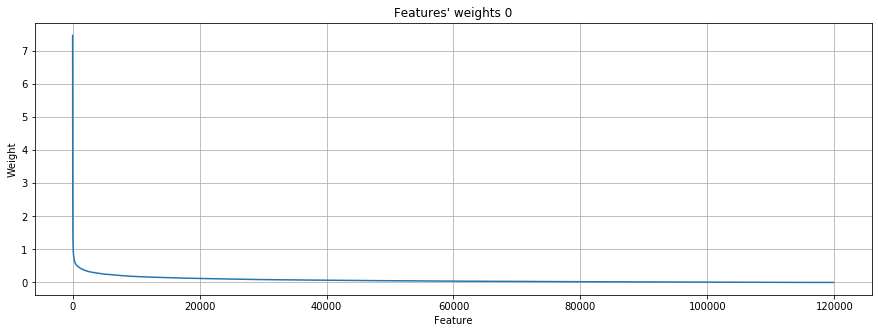

In [29]:
# Data for plotting
for i in range(weights.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights[i].data.shape[0]), sorted(abs(weights[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [30]:
# select most important features
cutoff_0 = 0.2
selected_features_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights[0].data)), weights[0].indices), reverse=True) if i[0] > cutoff_0]

In [31]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features = set()
for f in selected_features_0:
    selected_features.add(f[1])
print('Selected ' + str(len(selected_features)) + ' features')    

Selected 8234 features


Now retry grid search using only selected features

In [32]:
train_X_fs = train_X[:, list(selected_features)]
train_y_fs = train_y
valid_X_fs = valid_X[:, list(selected_features)]
valid_y_fs = valid_y

In [33]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs.fit(train_X_fs, train_y_fs)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs.cv_results_['mean_test_score']
    stds = clf_fs.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   13.2s finished


[LibSVM]Best parameters set found on development set:

{'C': 100.0}

Grid scores on development set:

0.000 (+/-0.000) for {'C': 0.001}
0.000 (+/-0.000) for {'C': 0.01}
0.000 (+/-0.000) for {'C': 0.1}
0.134 (+/-0.119) for {'C': 1.0}
0.578 (+/-0.082) for {'C': 10.0}
0.594 (+/-0.111) for {'C': 100.0}
0.594 (+/-0.109) for {'C': 1000.0}



New confusion matrix

In [34]:
# predictions
pred_y_fs = clf_fs.best_estimator_.predict(valid_X_fs)

F1 score on validation data: 0.5593869731800767
Recall on validation data: 0.5488721804511278


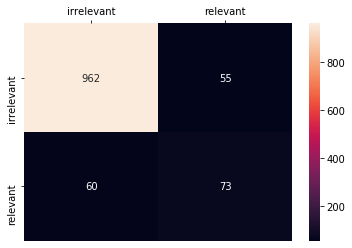

In [35]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 score on validation data: ' + str(f1_score(valid_y_fs, pred_y_fs)))
print('Recall on validation data: ' + str(recall_score(valid_y_fs, pred_y_fs)))
cm = confusion_matrix(valid_y_fs, pred_y_fs, labels=[0, 1])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','relevant'], yticklabels=['irrelevant','relevant'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


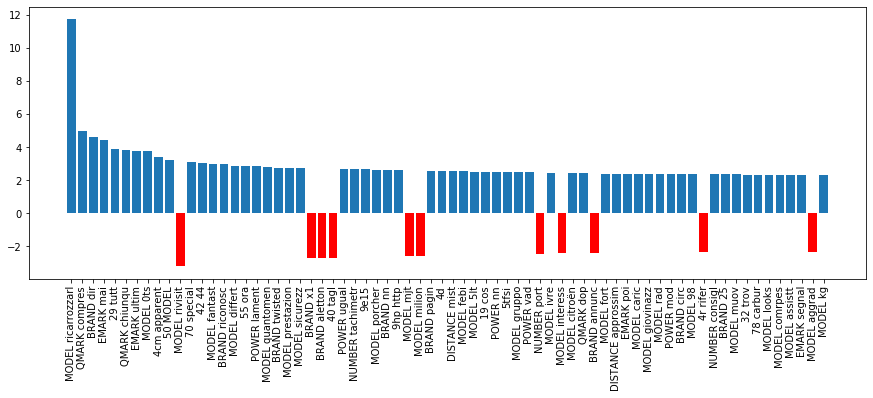

In [36]:
best_n = 70
feature_names = vec.get_feature_names()
for i in range(weights.shape[0]):
    print('### ' + str(i))
    fn = []
    fv = []
    f = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs.best_estimator_.coef_[i].data), clf_fs.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f)):
        fn.append(feature_names[f[j][1]])
        fv.append(f[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv[i]>0], [x for x in fv if x>0])
    plt.bar([i for i in range(best_n) if fv[i]<0], [x for x in fv if x<0], color='r')
    plt.xticks(range(best_n), fn, rotation='vertical')
    plt.show()

## Sentiment Classification

In [37]:
# get only rows for sentiment classification
train_dataset_X_snt = train_dataset_X[train_dataset_y != 'irrilevante']
train_dataset_y_snt = train_dataset_y[train_dataset_y != 'irrilevante']
valid_dataset_X_snt = valid_dataset_X[valid_dataset_y != 'irrilevante']
valid_dataset_y_snt = valid_dataset_y[valid_dataset_y != 'irrilevante']
test_dataset_X_snt = test_dataset_X[test_dataset_y != 'irrilevante']
test_dataset_y_snt = test_dataset_y[test_dataset_y != 'irrilevante']

train_concat_snt = []
for i in range(len(train_dataset_X_snt)):
    train_concat_snt.append(combine_text_quote(train_dataset_X_snt['TESTO'].iloc[i], train_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat_snt = []
for i in range(len(valid_dataset_X_snt)):
    valid_concat_snt.append(combine_text_quote(valid_dataset_X_snt['TESTO'].iloc[i], valid_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat_snt = []
for i in range(len(test_dataset_X_snt)):
    test_concat_snt.append(combine_text_quote(test_dataset_X_snt['TESTO'].iloc[i], test_dataset_X_snt['(Testo Citato)'].iloc[i], divide_quote=False))

In [38]:
collections.Counter(train_dataset_y_snt)

Counter({'neutro': 229, 'positivo': 203, 'negativo': 99})

Vectorize

In [39]:
# VECTORIZE
vec_snt = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_snt = vec_snt.fit_transform(train_concat_snt)
valid_X_snt = vec_snt.transform(valid_concat_snt)
# training
train_y_snt = train_dataset_y[train_dataset_y != 'irrilevante'].replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)
# validation
valid_y_snt = valid_dataset_y[valid_dataset_y != 'irrilevante'].replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)

In [40]:
len(train_y_snt)

531

SVM_TFIDF_Classifier without feaure selection

In [41]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_snt = GridSearchCV(svm_clf_snt, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_snt.fit(train_X_snt, train_y_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_snt.cv_results_['mean_test_score']
    stds = clf_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_snt.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.201 (+/-0.001) for {'C': 0.001}
0.201 (+/-0.001) for {'C': 0.01}
0.201 (+/-0.001) for {'C': 0.1}
0.363 (+/-0.069) for {'C': 1.0}
0.410 (+/-0.155) for {'C': 10.0}
0.410 (+/-0.155) for {'C': 100.0}
0.410 (+/-0.155) for {'C': 1000.0}



[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [42]:
# predictions
pred_y_snt = clf_snt.best_estimator_.predict(valid_X_snt)

F1 score macro on validation data: 0.4223293006651114
F1 score micro on validation data: 0.49624060150375937


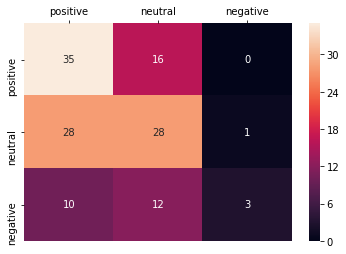

In [43]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 score macro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='macro')))
print('F1 score micro on validation data: ' + str(f1_score(valid_y_snt, pred_y_snt, average='micro')))
cm_snt = confusion_matrix(valid_y_snt, pred_y_snt, labels=[1, 2, 3])
ax = sns.heatmap(cm_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

Feature Selection

In [44]:
weights_snt = clf_snt.best_estimator_.coef_
print(weights.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(1, 156369)


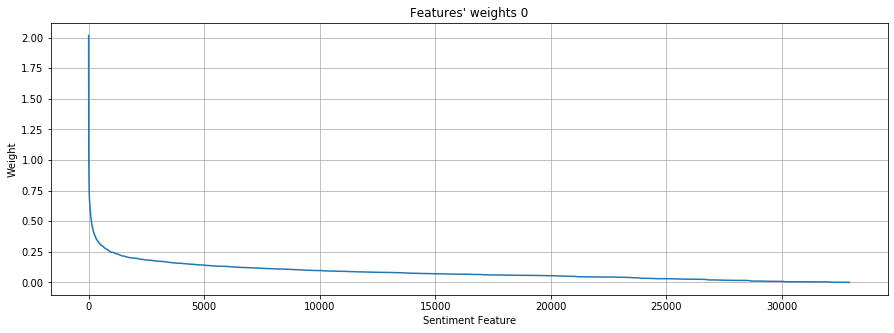

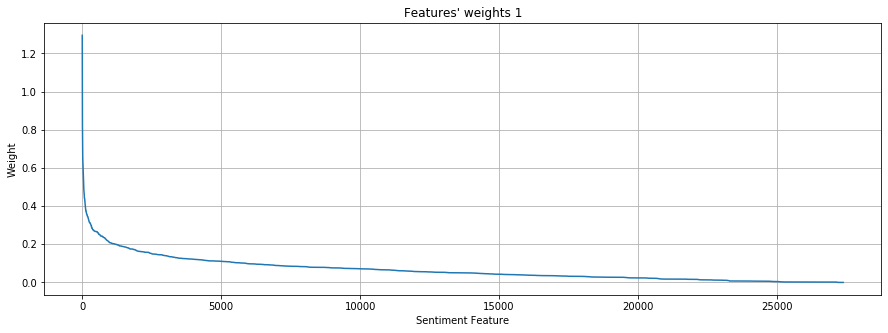

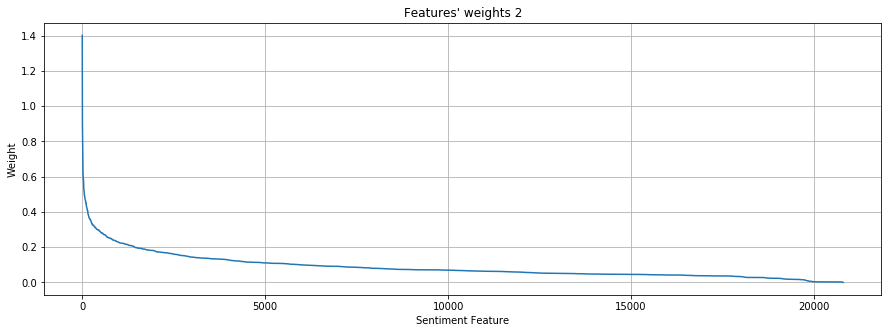

In [45]:
# Data for plotting
for i in range(weights_snt.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_snt[i].data.shape[0]), sorted(abs(weights_snt[i].data), reverse = True))
    ax.set(xlabel='Sentiment Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [46]:
# select most important features
cutoff_0 = 0.15
selected_features_snt_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[0].data)), weights_snt[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.1
selected_features_snt_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[1].data)), weights_snt[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.1
selected_features_snt_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_snt[2].data)), weights_snt[2].indices), reverse=True) if i[0] > cutoff_2]

In [47]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_snt = set()
for f in selected_features_snt_0:
    selected_features_snt.add(f[1])
for f in selected_features_snt_1:
    selected_features_snt.add(f[1])
for f in selected_features_snt_2:
    selected_features_snt.add(f[1])
print('Selected ' + str(len(selected_features_snt)) + ' features')    

Selected 9657 features


Retry with selected features

In [48]:
train_X_fs_snt = train_X_snt[:, list(selected_features_snt)]
train_y_fs_snt = train_y_snt
valid_X_fs_snt = valid_X_snt[:, list(selected_features_snt)]
valid_y_fs_snt = valid_y_snt

In [49]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_snt = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_snt = GridSearchCV(svm_clf_fs, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_snt.fit(train_X_fs_snt, train_y_fs_snt)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_snt.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_snt.cv_results_['mean_test_score']
    stds = clf_fs_snt.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.201 (+/-0.001) for {'C': 0.001}
0.201 (+/-0.001) for {'C': 0.01}
0.201 (+/-0.001) for {'C': 0.1}
0.397 (+/-0.065) for {'C': 1.0}
0.465 (+/-0.114) for {'C': 10.0}
0.465 (+/-0.114) for {'C': 100.0}
0.465 (+/-0.114) for {'C': 1000.0}



[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [50]:
# predictions
pred_y_fs_snt = clf_fs_snt.best_estimator_.predict(valid_X_fs_snt)

F1 macro score on validation data: 0.45164987040070037
F1 micro score on validation data: 0.5338345864661654


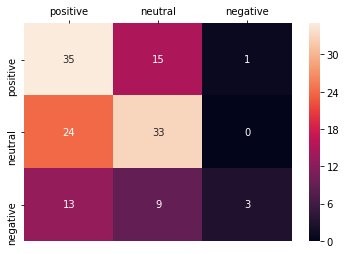

In [51]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_snt, pred_y_fs_snt, average='micro')))
cm_fs_snt = confusion_matrix(valid_y_fs_snt, pred_y_fs_snt, labels=[1, 2, 3])
ax = sns.heatmap(cm_fs_snt, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

### 0


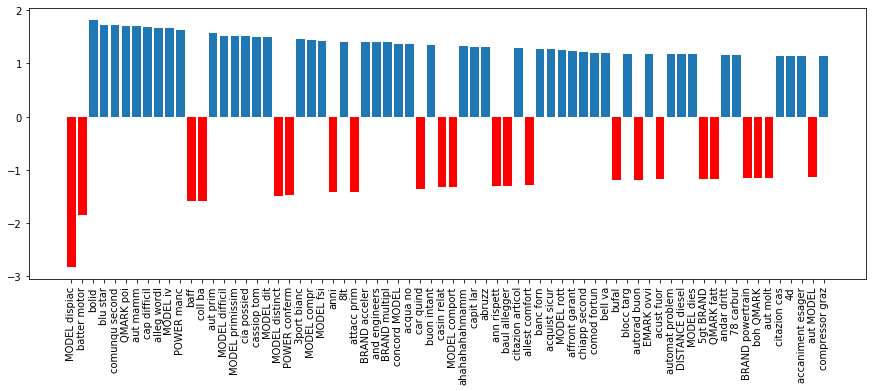

### 1


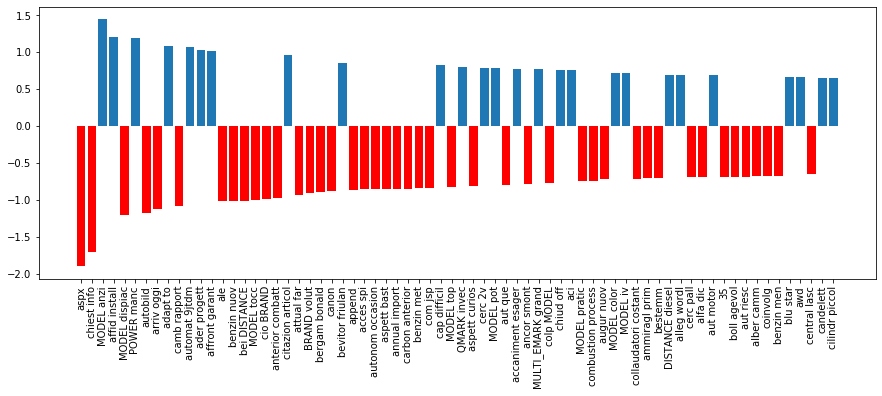

### 2


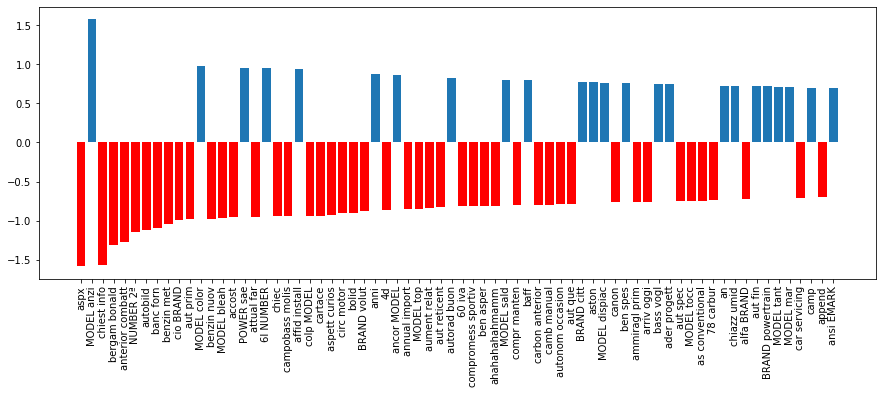

In [52]:
best_n = 70
feature_names_snt = vec_snt.get_feature_names()
for i in range(weights_snt.shape[0]):
    print('### ' + str(i))
    fn_snt = []
    fv_snt = []
    f_snt = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_snt.best_estimator_.coef_[i].data), clf_fs_snt.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_snt)):
        fn_snt.append(feature_names_snt[f_snt[j][1]])
        fv_snt.append(f_snt[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_snt[i]>0], [x for x in fv_snt if x>0])
    plt.bar([i for i in range(best_n) if fv_snt[i]<0], [x for x in fv_snt if x<0], color='r')
    plt.xticks(range(best_n), fn_snt, rotation='vertical')
    plt.show()

## Classification with 4 labels

In [53]:
# get only rows for sentiment classification
train_dataset_X_4l = train_dataset_X
train_dataset_y_4l = train_dataset_y
valid_dataset_X_4l = valid_dataset_X
valid_dataset_y_4l = valid_dataset_y
test_dataset_X_4l = test_dataset_X
test_dataset_y_4l = test_dataset_y

train_concat_4l = []
for i in range(len(train_dataset_X_4l)):
    train_concat_4l.append(combine_text_quote(train_dataset_X_4l['TESTO'].iloc[i], train_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))
valid_concat_4l = []
for i in range(len(valid_dataset_X_4l)):
    valid_concat_4l.append(combine_text_quote(valid_dataset_X_4l['TESTO'].iloc[i], valid_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))
test_concat_4l = []
for i in range(len(test_dataset_X_4l)):
    test_concat_4l.append(combine_text_quote(test_dataset_X_4l['TESTO'].iloc[i], test_dataset_X_4l['(Testo Citato)'].iloc[i], divide_quote=False))

In [54]:
collections.Counter(train_dataset_y_4l)

Counter({'irrilevante': 4065, 'neutro': 229, 'positivo': 203, 'negativo': 99})

Vectorization

In [55]:
# VECTORIZE
vec_4l = TfidfVectorizer(ngram_range=(1,2), lowercase=False)
#train_dataset_X = vec.fit_transform(train_dataset_X)

# final dataset for the classification
train_X_4l = vec_4l.fit_transform(train_concat_4l)
valid_X_4l = vec_4l.transform(valid_concat_4l)
# training
train_y_4l = train_dataset_y_4l.replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)
# validation
valid_y_4l = valid_dataset_y_4l.replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3)

In [56]:
len(valid_y_4l)

1150

SVM _TFIDF Classifier

In [57]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_4l = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

# f1, f1_macro (for multiclass), recall
scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_4l = GridSearchCV(svm_clf_4l, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_4l.fit(train_X_4l, train_y_4l)

    print("Best parameters set found on development set:")
    print()
    print(clf_4l.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_4l.cv_results_['mean_test_score']
    stds = clf_4l.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_4l.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.7min finished


[LibSVM]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.248 (+/-0.022) for {'C': 1.0}
0.279 (+/-0.025) for {'C': 10.0}
0.283 (+/-0.019) for {'C': 100.0}
0.287 (+/-0.028) for {'C': 1000.0}



Refit with best parameters and then draw confusion matrix on validation data

In [58]:
# predictions
pred_y_4l = clf_4l.best_estimator_.predict(valid_X_4l)

F1 macro score on validation data: 0.3850178680725323
F1 micro score on validation data: 0.8895652173913043


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


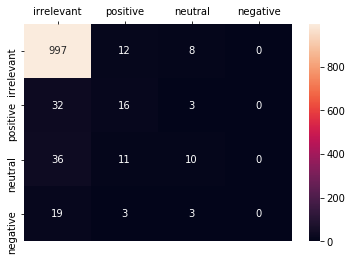

In [59]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_4l, pred_y_4l, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_4l, pred_y_4l, average='micro')))
cm_all = confusion_matrix(valid_y_4l, pred_y_4l, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm_all, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Features selection. Plot by descending weight


In [60]:
weights_4l = clf_4l.best_estimator_.coef_
print(weights_4l.shape)
# 6 perchè fa un classifictore per ogni coppia di labels (ovr) -> verificare

(6, 156369)


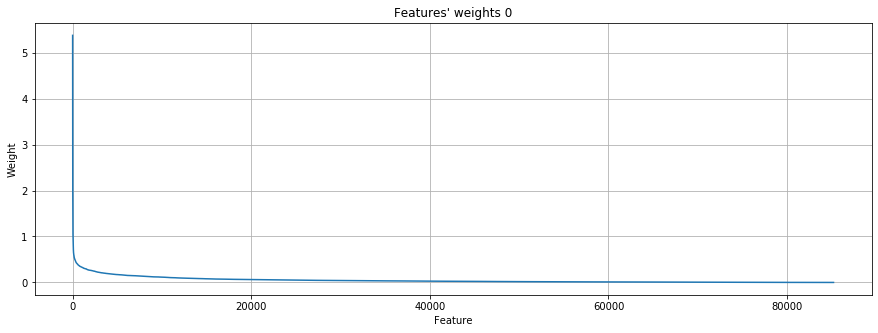

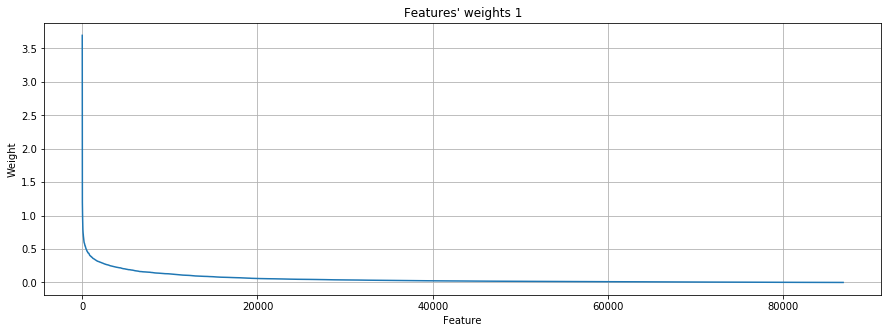

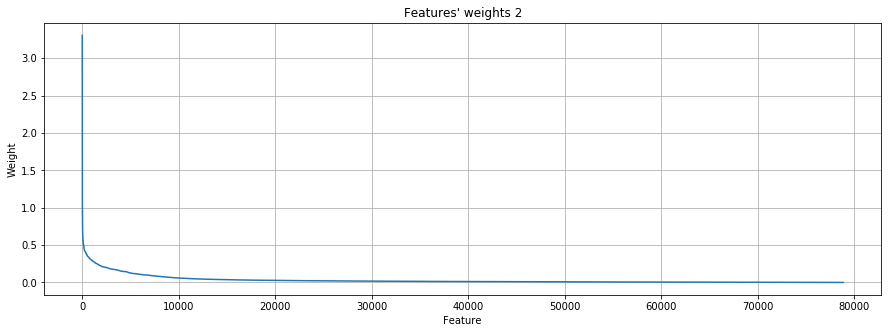

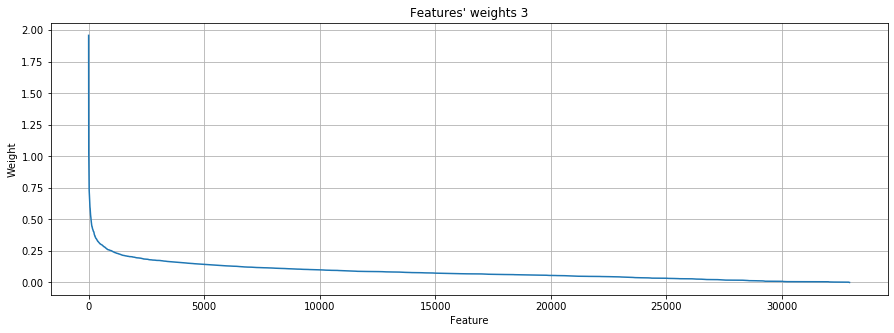

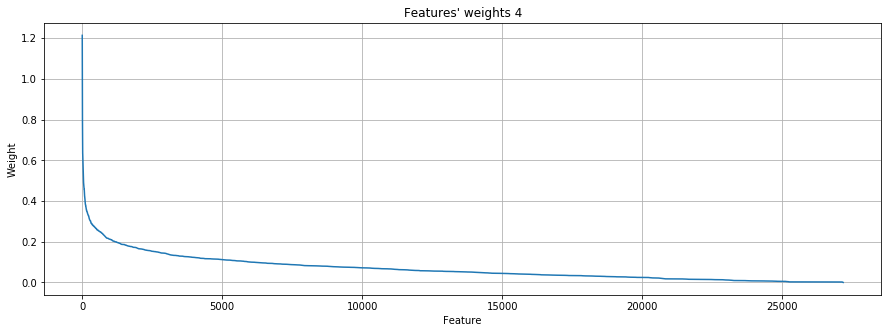

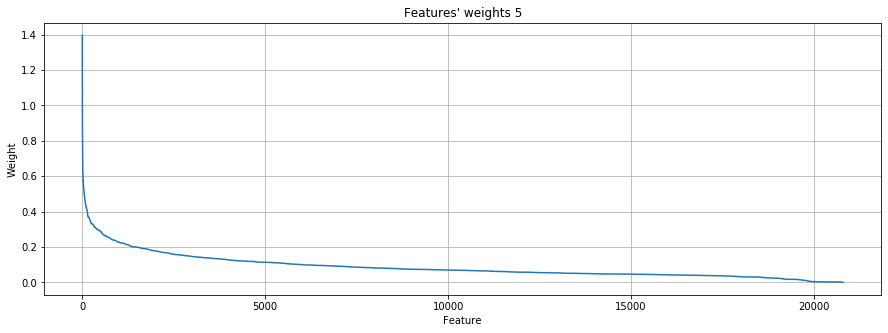

In [61]:
# Data for plotting
for i in range(weights_4l.shape[0]):
    fig, ax = plt.subplots(figsize=(15,5))
    ax.plot(range(weights_4l[i].data.shape[0]), sorted(abs(weights_4l[i].data), reverse = True))
    ax.set(xlabel='Feature', ylabel='Weight', title='Features\' weights ' + str(i))
    ax.grid()
    #fig.savefig("test.png")
    plt.show()

In [104]:
# select most important features
cutoff_0 = 0.05
selected_features_4l_0 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[0].data)), weights_4l[0].indices), reverse=True) if i[0] > cutoff_0]
cutoff_1 = 0.05
selected_featu1res_4l_1 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[1].data)), weights_4l[1].indices), reverse=True) if i[0] > cutoff_1]
cutoff_2 = 0.1
selected_features_4l_2 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[2].data)), weights_4l[2].indices), reverse=True) if i[0] > cutoff_2]
cutoff_3 = 0.1
selected_features_4l_3 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[3].data)), weights_4l[3].indices), reverse=True) if i[0] > cutoff_3]
cutoff_4 = 0.1
selected_features_4l_4 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[4].data)), weights_4l[4].indices), reverse=True) if i[0] > cutoff_4]
cutoff_5 = 0.1
selected_features_4l_5 = [i for i in sorted(zip(map(lambda x: round(x, 4), abs(weights_4l[5].data)), weights_4l[5].indices), reverse=True) if i[0] > cutoff_5]

In [105]:
# take the union of selected features (a word important for a classification may be not important for other classifications)
selected_features_4l = set()
for f in selected_features_4l:
    selected_features_4l.add(f[1])
for f in selected_features_4l_1:
    selected_features_4l.add(f[1])
for f in selected_features_4l_2:
    selected_features_4l.add(f[1])
for f in selected_features_4l_3:
    selected_features_4l.add(f[1])
for f in selected_features_4l_4:
    selected_features_4l.add(f[1])
for f in selected_features_4l_5:
    selected_features_4l.add(f[1])
print('Selected ' + str(len(selected_features_4l)) + ' features')    

Selected 94099 features


Now retry grid search using only selected features

In [106]:
train_X_fs_4l = train_X_4l[:, list(selected_features_4l)]
train_y_fs_4l = train_y_4l
valid_X_fs_4l = valid_X_4l[:, list(selected_features_4l)]
valid_y_fs_4l = valid_y_4l

In [107]:
skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
svm_clf_fs_4l = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)

tuned_parameters = {'C': np.logspace(-3, 3, 7),}

scores = ['f1_macro']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf_fs_4l = GridSearchCV(svm_clf_fs_4l, tuned_parameters, cv=skf, n_jobs=-1, scoring=score, verbose=2)
    clf_fs_4l.fit(train_X_fs_4l, train_y_fs_4l)

    print("Best parameters set found on development set:")
    print()
    print(clf_fs_4l.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf_fs_4l.cv_results_['mean_test_score']
    stds = clf_fs_4l.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf_fs_4l.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
    print()

# Tuning hyper-parameters for f1_macro

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  1.3min finished


[LibSVM]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.235 (+/-0.000) for {'C': 0.001}
0.235 (+/-0.000) for {'C': 0.01}
0.235 (+/-0.000) for {'C': 0.1}
0.246 (+/-0.014) for {'C': 1.0}
0.307 (+/-0.035) for {'C': 10.0}
0.309 (+/-0.041) for {'C': 100.0}
0.313 (+/-0.044) for {'C': 1000.0}



In [108]:
# predictions
pred_y_fs_4l = clf_fs_4l.best_estimator_.predict(valid_X_fs_4l)

F1 macro score on validation data: 0.3825421283048402
F1 micro score on validation data: 0.8843478260869565


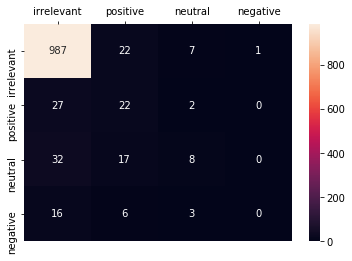

In [109]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_fs_4l, pred_y_fs_4l, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_fs_4l, pred_y_fs_4l, average='micro')))
cm = confusion_matrix(valid_y_fs_4l, pred_y_fs_4l, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

Most important features

### 0


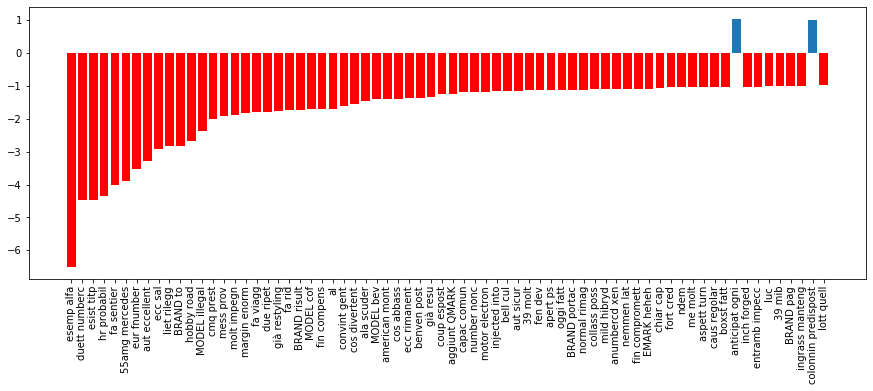

### 1


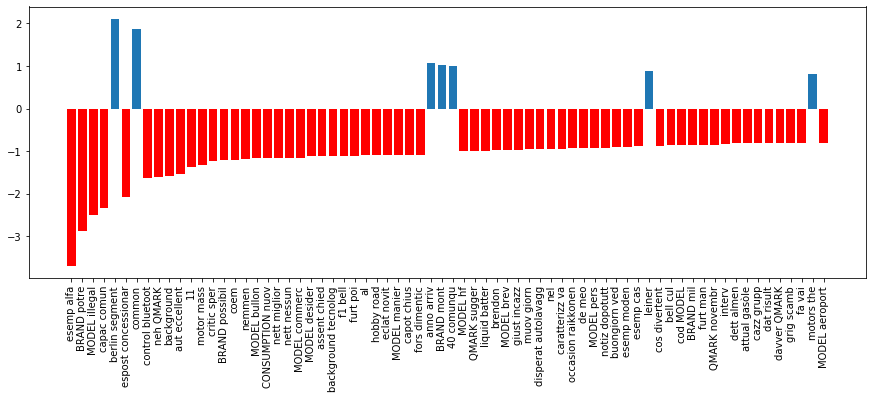

### 2


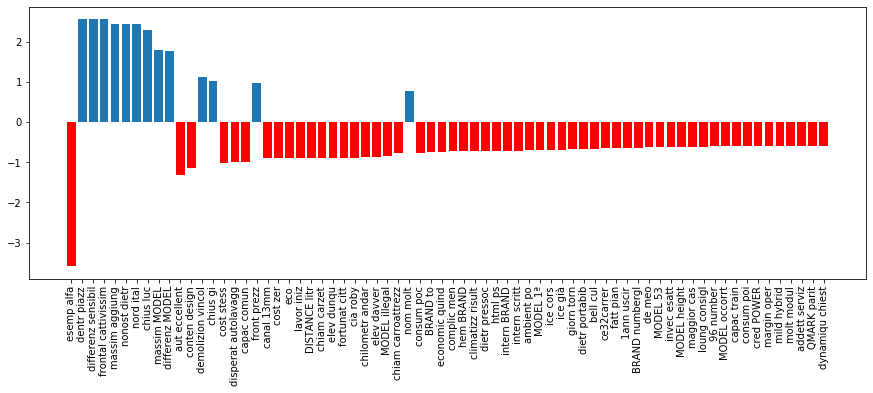

### 3


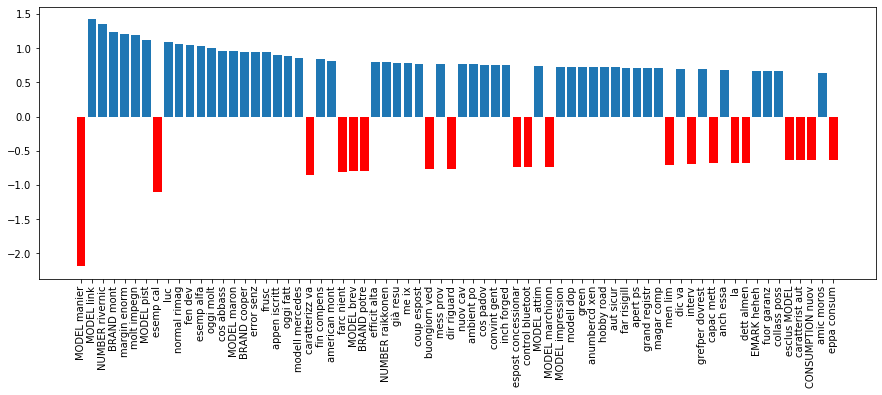

### 4


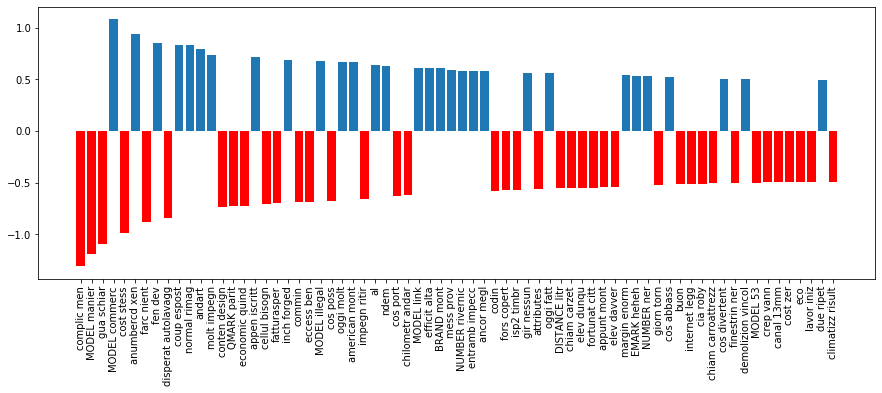

### 5


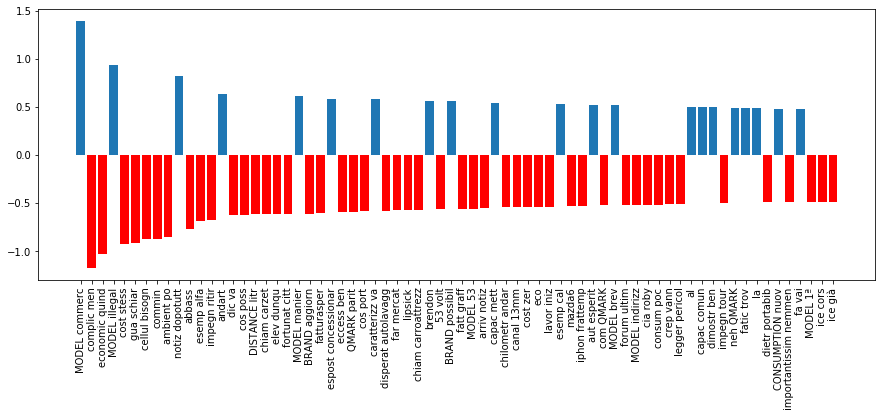

In [110]:
best_n = 70
feature_names_4l = vec_4l.get_feature_names()
for i in range(weights_4l.shape[0]):
    print('### ' + str(i))
    fn_4l = []
    fv_4l = []
    f_4l = [i for i in sorted(zip(map(lambda x: round(x, 4), clf_fs_4l.best_estimator_.coef_[i].data), clf_fs_4l.best_estimator_.coef_[i].indices), reverse=True, key=lambda k: abs(k[0]))][:best_n]
    for j in range(len(f_4l)):
        fn_4l.append(feature_names_4l[f_4l[j][1]])
        fv_4l.append(f_4l[j][0])
        #print(str(feature_names[f[j][1]]) + ': ' + str(f[j][0]))
    fig, ax = plt.subplots(figsize=(15,5))
    plt.bar([i for i in range(best_n) if fv_4l[i]>0], [x for x in fv_4l if x>0])
    plt.bar([i for i in range(best_n) if fv_4l[i]<0], [x for x in fv_4l if x<0], color='r')
    plt.xticks(range(best_n), fn_4l, rotation='vertical')
    plt.show()

## BPEF for sentiment classification

In [111]:
class Dataset:
    
    # input dataset with labels just positive/neutral/negative
    def __init__(self, text, quote, label, feature, ner=False, use_stemmer=False, combine_text_quote=False):
        if feature not in ['word', 'pos', 'swnt']:
            raise ValueError('feature parameter must be in (\'word\', \'pos\', \'swnt\')')
        self.text = text
        self.quote = quote
        self.label = label
        self.label = self.label.replace('positivo', 0)
        self.label = self.label.replace('neutro', 1)
        self.label = self.label.replace('negativo', 2)
        self.feature = feature
        self.ner = ner
        self.use_stemmer = use_stemmer
        self.combine_text_quote = combine_text_quote
        self.combined = pd.Series()
        self.vec = CountVectorizer(ngram_range=(1,2), lowercase=False)
        self.vectorized_before_fs = None
        self.vectorized_after_fs = None
        self.selected_features = None
        self.features_entropy = None
        # fit model -> transform
        self.__fit()
        self.__feature_selection()
        # apply features selection
        self.selected_features_after_fs = self.selected_features
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        
        
    def __fit(self):
        # preprocess
        self.pp = Preprocessor()
        for i in range(len(self.text)):
            self.text.iloc[i] = pp.preprocessText(self.text.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if self.quote is not None:
            for i in range(len(self.quote)):
                self.quote.iloc[i] = pp.preprocessText(self.quote.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if self.quote is not None:
            for i in range(len(self.text)):
                comb = combine_text_quote(self.text.iloc[i], self.quote.iloc[i], divide_quote=self.combine_text_quote)
                self.combined.loc[i] = comb
        else:
            self.combined = self.text
        # vectorization (count vectorizer vediamo)
        self.vectorized_before_fs = self.vec.fit_transform(self.combined)
        
            
    def transform(self, text, quote):
        combined = pd.Series()
        for i in range(len(text)):
            text.iloc[i] = self.pp.preprocessText(text.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        if quote is not None:
            for i in range(len(quote)):
                quote.iloc[i] = self.pp.preprocessText(quote.iloc[i], method=self.feature, use_stemmer=self.use_stemmer, ner=self.ner)
        # combine text quote
        if quote is not None:
            for i in range(len(text)):
                comb = combine_text_quote(text.iloc[i], quote.iloc[i], divide_quote=self.combine_text_quote)
                combined.loc[i] = comb
        else:
            combined = text
        # vectorization (count vectorizer vediamo) and feature selection
        vectorized = self.vec.transform(combined)[:, self.selected_features_after_fs]
        return vectorized
    
    # https://www3.nd.edu/~rjohns15/cse40647.sp14/www/content/lectures/23%20-%20Decision%20Trees%202.pdf
    # https://pypi.org/project/info-gain/
    def __feature_selection(self):
        self.selected_features = [i for i in range(self.vectorized_before_fs.shape[1])]
        self.features_entropy = []
        
        #H_class = scipy.stats.entropy(self.label.value_counts())
        
        # for each feature calculate information gain
        for feat_idx in range(self.vectorized_before_fs.shape[1]):
            # print
            sys.stdout.write("\r IG: " + str(feat_idx) + '/' + str(self.vectorized_before_fs.shape[1]-1))
            sys.stdout.flush()
            '''
            H_feat = 0
            values = set(np.append(self.vectorized_before_fs[:, feat_idx].data, 0)) # zero added manually bcause sparse matrix is stupid
            # for each value calculate the conditional entropy
            for v in values:
                indexes = [i for i in range(self.vectorized_before_fs.shape[0]) if self.vectorized_before_fs[i, feat_idx] == v]
                feat_list = self.label[indexes]
                # entropy
                feat_prob = len(feat_list) / self.vectorized_before_fs.shape[0]
                H_feat += feat_prob * scipy.stats.entropy(feat_list.value_counts())
            #print(H_feat)
            # information gain of the feature
            IG = H_class - H_feat
            '''
            IG = info_gain.info_gain(self.label, self.vectorized_before_fs[:, feat_idx].toarray().ravel())
            self.features_entropy.append(IG)
            
    def plot_IG_feature(self):
        plot_ig = sorted(self.features_entropy, reverse=True)
        plt.subplots(figsize=(15,5))
        plt.semilogy(range(len(plot_ig)), plot_ig)
        plt.show()
        
    def cut_features(self, cutoff_value):
        # cut and apply features selection
        self.selected_features_after_fs = [i for i in range(len(self.features_entropy)) if self.features_entropy[i] > cutoff_value]
        self.vectorized_after_fs = self.vectorized_before_fs[:, self.selected_features_after_fs]
        

### BPEF

Create dataset dictionary

In [112]:
np.random.seed(42)

dataset_bpef = original_dataset.copy()
# split 80% training and 20% test
train_dataset_X_bpef, test_dataset_X_bpef, train_dataset_y_bpef, test_dataset_y_bpef = train_test_split(dataset_bpef[['TESTO', '(Testo Citato)']], dataset_bpef[column], test_size=0.2, stratify=dataset_bpef[column], shuffle=True, random_state=52)
# split validation
train_dataset_X_bpef, valid_dataset_X_bpef, train_dataset_y_bpef, valid_dataset_y_bpef = train_test_split(train_dataset_X_bpef, train_dataset_y_bpef, test_size=0.2, stratify=train_dataset_y_bpef, shuffle=True, random_state=52)

train_dataset_X_bpef = train_dataset_X_bpef[train_dataset_y_bpef != 'irrilevante']
train_dataset_y_bpef = train_dataset_y_bpef[train_dataset_y_bpef != 'irrilevante']
valid_dataset_X_bpef = valid_dataset_X_bpef[valid_dataset_y_bpef != 'irrilevante']
valid_dataset_y_bpef = valid_dataset_y_bpef[valid_dataset_y_bpef != 'irrilevante']
test_dataset_X_bpef = test_dataset_X_bpef[test_dataset_y_bpef != 'irrilevante']
test_dataset_y_bpef = test_dataset_y_bpef[test_dataset_y_bpef != 'irrilevante']

In [113]:
collections.Counter(train_dataset_y_bpef)

Counter({'neutro': 229,
         'positivo': 172,
         'negativo': 93,
         'molto positivo': 31,
         'molto negativo': 6})

word False
 IG: 42314/42314

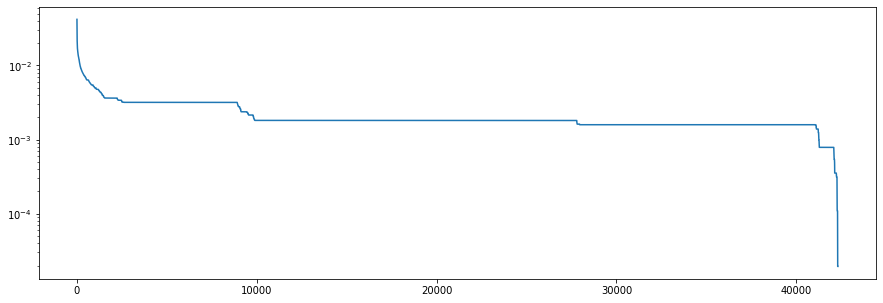

word True
 IG: 38804/38804

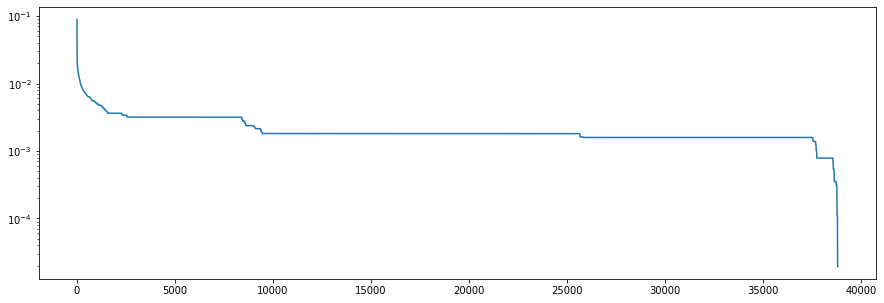

pos False
 IG: 49260/49260

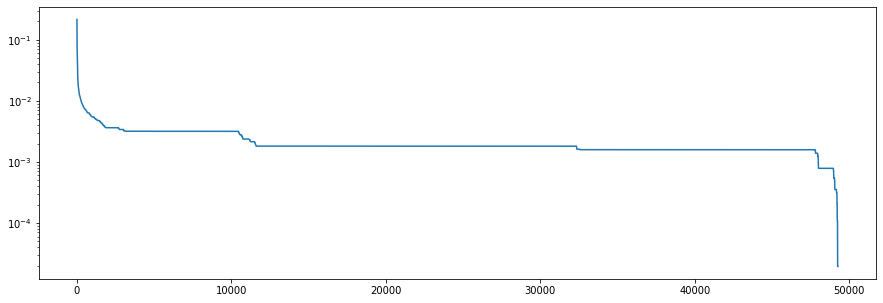

pos True
 IG: 45023/45023

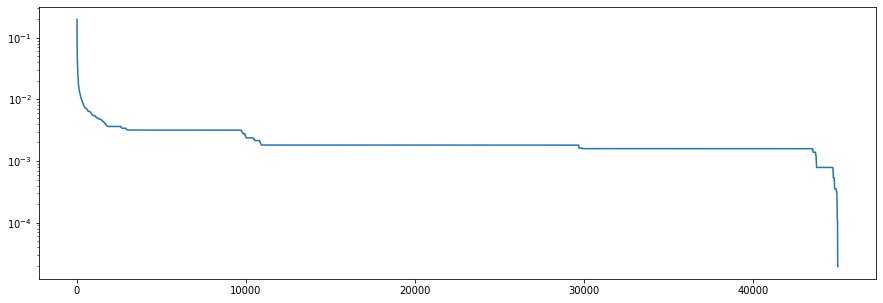

swnt False
 IG: 36991/36991

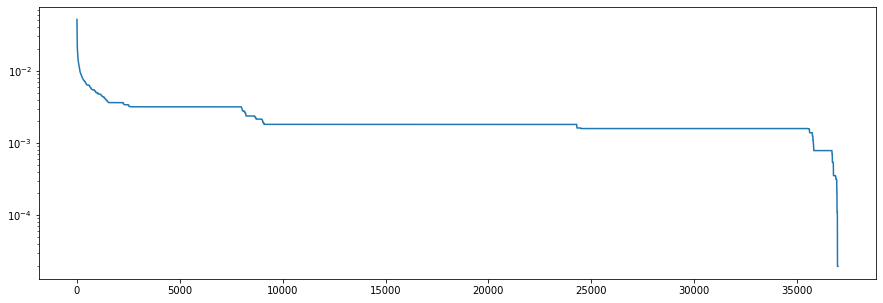

swnt True
 IG: 33601/33601

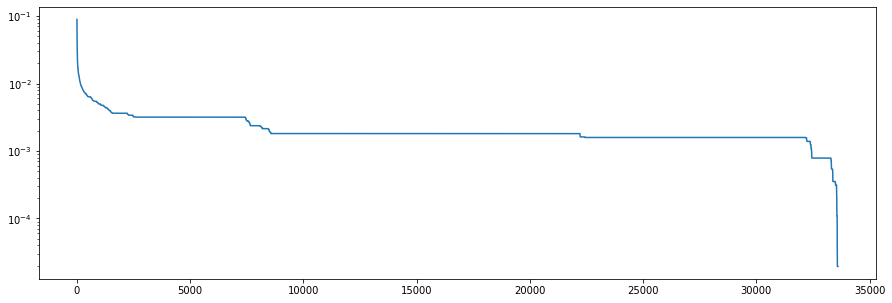

In [121]:
feature_values = ['word', 'pos', 'swnt']
ner_values = [False, True]
column = 'Motore'

train_X_bpef = train_dataset_X_bpef
train_y_bpef = train_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)
valid_X_bpef = valid_dataset_X_bpef
valid_y_bpef = valid_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)
test_X_bpef = test_dataset_X_bpef
test_y_bpef = test_dataset_y_bpef.replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3)


dataset_dict = {}
for f in feature_values:
    for n in ner_values:
        print(f + ' ' + str(n))
        
        d = Dataset(text=train_X_bpef['TESTO'].copy(), quote=train_X_bpef['(Testo Citato)'].copy(), label=train_y_bpef.copy(), feature=f, ner=n, use_stemmer=True, combine_text_quote=False)
        
        d.plot_IG_feature()
        dataset_dict[(f, n)] = d


In [126]:
sorted(dataset_dict[('word', False)].features_entropy, reverse=True)[10000]

0.001813711750586311

In [127]:
# cut less informative features -> cutoff at 0.0019 (heuristic)
for k in dataset_dict.keys():
    dataset_dict[k].cut_features(0.0019)
    print(str(k) + ' ' + str(len(dataset_dict[k].selected_features_after_fs)))

('word', False) 9860
('word', True) 9433
('pos', False) 11580
('pos', True) 10887
('swnt', False) 9082
('swnt', True) 8547


In [128]:
class BPEF:
    
    def __init__(self, dict_dataset):
        self.dict_dataset = dict_dataset
        
    # text plain, quote plain, labels numerical
    def train(self, text, quote, labels):
        self.classifiers_dict = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        # for each feature type -> keys ('feature', True/False)
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()
            quote_copy = quote.copy()
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                
                if c == 'svm':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    svmclf = svm.SVC(kernel='linear', decision_function_shape='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7),}
                    clf = GridSearchCV(svmclf, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'logreg':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    logreg = LogisticRegression(multi_class='ovr', verbose=2, random_state=42)
                    tuned_parameters = {'C': np.logspace(-3, 3, 7)}
                    clf = GridSearchCV(logreg, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X, labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'naibay':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    naibay = GaussianNB()
                    tuned_parameters = {}
                    clf = GridSearchCV(naibay, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
                    
                elif c == 'rndfst':
                    # train, estimate C with gridsearch
                    skf = StratifiedKFold(n_splits=5, random_state=42, shuffle=False)
                    rndfst = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)
                    tuned_parameters = {'n_estimators': [201,501], 'max_features': ['auto', 'log2'], 'max_depth' : [10, 100], 'criterion' :['gini', 'entropy']}
                    clf = GridSearchCV(rndfst, tuned_parameters, cv=skf, n_jobs=-1, scoring='f1_macro', verbose=2)
                    clf.fit(X.toarray(), labels)
                    print("Best parameters set found on development set:")
                    print()
                    print(clf.best_params_)
                    print()
                    print("Grid scores on development set:")
                    print()
                    means = clf.cv_results_['mean_test_score']
                    stds = clf.cv_results_['std_test_score']
                    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
                        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))
                    print()
                    # add classifier to dictionary
                    self.classifiers_dict[k + (c, )] = clf.best_estimator_
            
        
    # text quote plain
    def predict(self, text, quote):
        text_copy = text.copy()
        quote_copy = quote.copy()
        predictions = {}
        keys = self.dict_dataset.keys()
        classifiers = ['svm', 'logreg', 'naibay', 'rndfst']
        for k in keys:
            d = self.dict_dataset[k]
            # train set
            text_copy = text.copy()
            quote_copy = quote.copy()
            X = d.transform(text_copy, quote_copy)
            # train every classifier
            for c in classifiers:
                print('######## ' + str((k + (c, ))) + ' ########')
                # make prediction
                pred = self.classifiers_dict[k + (c, )].predict(X.toarray())
                predictions[k + (c, )] = pred
        # calculate the ensemble
        fin_pred = []
        for i in range(text_copy.shape[0]):
            curr_pred = []
            for k in keys:
                for c in classifiers:
                    curr_pred.append(predictions[k + (c, )][i])
            fin_pred.append(max(set(curr_pred), key = curr_pred.count))
        return fin_pred
                

In [129]:
bpef = BPEF(dataset_dict)

In [130]:
bpef.train(train_X_bpef['TESTO'], train_X_bpef['(Testo Citato)'], train_y_bpef)

######## ('word', False, 'svm') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.236 (+/-0.041) for {'C': 0.001}
0.328 (+/-0.072) for {'C': 0.01}
0.410 (+/-0.105) for {'C': 0.1}
0.417 (+/-0.090) for {'C': 1.0}
0.410 (+/-0.096) for {'C': 10.0}
0.410 (+/-0.096) for {'C': 100.0}
0.410 (+/-0.096) for {'C': 1000.0}

######## ('word', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.3s finished
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.364 (+/-0.054) for {'C': 0.001}
0.388 (+/-0.057) for {'C': 0.01}
0.401 (+/-0.071) for {'C': 0.1}
0.409 (+/-0.068) for {'C': 1.0}
0.412 (+/-0.063) for {'C': 10.0}
0.421 (+/-0.056) for {'C': 100.0}
0.425 (+/-0.048) for {'C': 1000.0}

######## ('word', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{}

Grid scores on development set:

0.466 (+/-0.018) for {}

######## ('word', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.8s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.345 (+/-0.050) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.343 (+/-0.052) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.272 (+/-0.038) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.270 (+/-0.026) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.357 (+/-0.061) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.361 (+/-0.072) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.359 (+/-0.084) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.359 (+/-0.077) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.256 (+/-0.058) for {'C': 0.001}
0.349 (+/-0.067) for {'C': 0.01}
0.407 (+/-0.081) for {'C': 0.1}
0.403 (+/-0.079) for {'C': 1.0}
0.405 (+/-0.081) for {'C': 10.0}
0.405 (+/-0.081) for {'C': 100.0}
0.405 (+/-0.081) for {'C': 1000.0}

######## ('word', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.348 (+/-0.035) for {'C': 0.001}
0.377 (+/-0.060) for {'C': 0.01}
0.388 (+/-0.068) for {'C': 0.1}
0.408 (+/-0.106) for {'C': 1.0}
0.430 (+/-0.097) for {'C': 10.0}
0.426 (+/-0.102) for {'C': 100.0}
0.421 (+/-0.109) for {'C': 1000.0}

######## ('word', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.486 (+/-0.045) for {}

######## ('word', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}

Grid scores on development set:

0.352 (+/-0.032) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.346 (+/-0.042) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.265 (+/-0.039) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.266 (+/-0.040) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.358 (+/-0.082) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.361 (+/-0.083) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.342 (+/-0.072) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.348 (+/-0.079) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.302 (+/-0.056) for {'C': 0.001}
0.358 (+/-0.121) for {'C': 0.01}
0.377 (+/-0.080) for {'C': 0.1}
0.393 (+/-0.070) for {'C': 1.0}
0.383 (+/-0.063) for {'C': 10.0}
0.383 (+/-0.063) for {'C': 100.0}
0.383 (+/-0.063) for {'C': 1000.0}

######## ('pos', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.337 (+/-0.056) for {'C': 0.001}
0.361 (+/-0.048) for {'C': 0.01}
0.370 (+/-0.074) for {'C': 0.1}
0.369 (+/-0.092) for {'C': 1.0}
0.367 (+/-0.073) for {'C': 10.0}
0.371 (+/-0.097) for {'C': 100.0}
0.382 (+/-0.088) for {'C': 1000.0}

######## ('pos', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.496 (+/-0.045) for {}

######## ('pos', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.6s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.3min finished


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 501}

Grid scores on development set:

0.355 (+/-0.056) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.356 (+/-0.057) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.295 (+/-0.026) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.306 (+/-0.023) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.360 (+/-0.063) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.355 (+/-0.036) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.350 (+/-0.037) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.363 (+/-0.066) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.5s finished


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.310 (+/-0.032) for {'C': 0.001}
0.343 (+/-0.086) for {'C': 0.01}
0.349 (+/-0.100) for {'C': 0.1}
0.362 (+/-0.081) for {'C': 1.0}
0.360 (+/-0.088) for {'C': 10.0}
0.360 (+/-0.088) for {'C': 100.0}
0.360 (+/-0.088) for {'C': 1000.0}

######## ('pos', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    2.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.343 (+/-0.045) for {'C': 0.001}
0.370 (+/-0.080) for {'C': 0.01}
0.381 (+/-0.075) for {'C': 0.1}
0.373 (+/-0.081) for {'C': 1.0}
0.377 (+/-0.073) for {'C': 10.0}
0.369 (+/-0.061) for {'C': 100.0}
0.377 (+/-0.043) for {'C': 1000.0}

######## ('pos', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.6s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.520 (+/-0.078) for {}

######## ('pos', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}

Grid scores on development set:

0.354 (+/-0.051) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.350 (+/-0.057) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.307 (+/-0.039) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.313 (+/-0.048) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.357 (+/-0.048) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.351 (+/-0.070) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.353 (+/-0.051) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.357 (+/-0.091) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 0.1}

Grid scores on development set:

0.255 (+/-0.052) for {'C': 0.001}
0.330 (+/-0.082) for {'C': 0.01}
0.430 (+/-0.097) for {'C': 0.1}
0.400 (+/-0.105) for {'C': 1.0}
0.397 (+/-0.081) for {'C': 10.0}
0.397 (+/-0.081) for {'C': 100.0}
0.397 (+/-0.081) for {'C': 1000.0}

######## ('swnt', False, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 1000.0}

Grid scores on development set:

0.359 (+/-0.067) for {'C': 0.001}
0.377 (+/-0.076) for {'C': 0.01}
0.376 (+/-0.053) for {'C': 0.1}
0.376 (+/-0.044) for {'C': 1.0}
0.386 (+/-0.066) for {'C': 10.0}
0.389 (+/-0.062) for {'C': 100.0}
0.392 (+/-0.063) for {'C': 1000.0}

######## ('swnt', False, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{}

Grid scores on development set:

0.459 (+/-0.028) for {}

######## ('swnt', False, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   21.4s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.2min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'entropy', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.350 (+/-0.056) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.349 (+/-0.056) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.285 (+/-0.020) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.265 (+/-0.040) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.364 (+/-0.079) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.356 (+/-0.079) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.366 (+/-0.064) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.363 (+/-0.052) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estim

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.4s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibSVM]Best parameters set found on development set:

{'C': 1.0}

Grid scores on development set:

0.257 (+/-0.053) for {'C': 0.001}
0.334 (+/-0.043) for {'C': 0.01}
0.426 (+/-0.092) for {'C': 0.1}
0.438 (+/-0.096) for {'C': 1.0}
0.438 (+/-0.093) for {'C': 10.0}
0.438 (+/-0.093) for {'C': 100.0}
0.438 (+/-0.093) for {'C': 1000.0}

######## ('swnt', True, 'logreg') ########
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[LibLinear]Best parameters set found on development set:

{'C': 10.0}

Grid scores on development set:

0.346 (+/-0.057) for {'C': 0.001}
0.364 (+/-0.047) for {'C': 0.01}
0.394 (+/-0.053) for {'C': 0.1}
0.410 (+/-0.045) for {'C': 1.0}
0.425 (+/-0.070) for {'C': 10.0}
0.414 (+/-0.063) for {'C': 100.0}
0.417 (+/-0.072) for {'C': 1000.0}

######## ('swnt', True, 'naibay') ########
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    0.5s finished


Best parameters set found on development set:

{}

Grid scores on development set:

0.473 (+/-0.024) for {}

######## ('swnt', True, 'rndfst') ########
Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.1s
[Parallel(n_jobs=-1)]: Done  80 out of  80 | elapsed:  1.1min finished
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


Best parameters set found on development set:

{'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}

Grid scores on development set:

0.353 (+/-0.071) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 201}
0.334 (+/-0.058) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto', 'n_estimators': 501}
0.280 (+/-0.039) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 201}
0.276 (+/-0.041) for {'criterion': 'gini', 'max_depth': 10, 'max_features': 'log2', 'n_estimators': 501}
0.370 (+/-0.060) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 201}
0.360 (+/-0.068) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'auto', 'n_estimators': 501}
0.362 (+/-0.042) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimators': 201}
0.349 (+/-0.074) for {'criterion': 'gini', 'max_depth': 100, 'max_features': 'log2', 'n_estimato

In [131]:
pred = bpef.predict(valid_X_bpef['TESTO'], valid_X_bpef['(Testo Citato)'])

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

F1 macro score on validation data: 0.46685340802987857
F1 micro score on validation data: 0.556390977443609


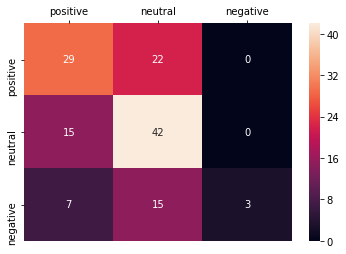

In [132]:
# 0=positivo, 1=neutro, 2=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_y_bpef, pred, average='micro')))
cm_fs_bpef = confusion_matrix(valid_y_bpef, pred, labels=[1, 2, 3])
ax = sns.heatmap(cm_fs_bpef, annot=True, xticklabels=['positive','neutral','negative'], yticklabels=['positive','neutral','negative'])
ax.xaxis.set_ticks_position('top')

In [133]:
print('positive: ' + str(list(train_y_bpef).count(1)))
print('neutral: ' + str(list(train_y_bpef).count(2)))
print('negative: ' + str(list(train_y_bpef).count(3)))

positive: 203
neutral: 229
negative: 99


Some errors

In [134]:
valid_X_bpef.iloc[0]

TESTO             Ciao Fabio sul gt3 997 3.6 si possono mettere ...
(Testo Citato)                                                     
Name: 6135, dtype: object

In [135]:
# positive predicted neutral
err_pos_neu = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==1 and pred[i]==2]
print(valid_X_bpef['TESTO'].iloc[err_pos_neu[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_pos_neu[1]])

Si come l'ho ordinata io con tutti gli accessori comunque il motore è molto silenzioso sembra a benzina 
################################################################
"@Matric: Ma l'hai ordinata come la volevi tu? Io mi sono dovuto accontentare di quello che c'era in arrivo (alla fine cambia solo il colore e motorizzazione e allestimento è quello voluto) ed è passato un mese e ancora nulla."


In [136]:
# neutral predicted positive
err_neu_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==2 and pred[i]==1]
print(valid_X_bpef['TESTO'].iloc[err_neu_pos[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_neu_pos[1]])

Ciao a tutti mi chiamo Federico e sono nuovo del forum. Sono un giovane appassionato di motori e da poco neopatentato. Finalmente è arrivato il momento di scegliere la mia prima auto ( e forse la mia prima Alfa Romeo ) ... Nonostante inizialmente in casa si pensasse ad un usato per iniziare ed avessimo cercato anche delle MiTo usate abbiamo iniziato a considerare l'acquisto di una MiTo Km0 anche approfittando del fatto che sia fuori produzione da poco. Me ne sono letteralmente innamorato e dopo il restyling l'auto mi piace ancora di più. Leggendo alcune discussioni ho sentito parlare molto bene della sua tenuta di strada ed agilità in curva sebbene l'assetto sia un po' rigido sui fondi sconnessi. Altri la considerano solo una Punto con il marchio Alfa Romeo...voi cosa dite ? Essendo neopatentato e facendo non molti km all'anno l'unica motorizzazione che posso prendere in considerazione è la 1.4 78 CV...secondo voi ne vale la pena oppure è poco brillante/sconsigliato per un tipo di macc

In [137]:
# negative predicted neutral
err_neg_pos = [i for i in range(valid_y_bpef.shape[0]) if valid_y_bpef.iloc[i]==3 and pred[i]==2]
print(valid_X_bpef['TESTO'].iloc[err_neg_pos[3]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_neg_pos[3]])

ha fatto un passo indietro perchè va più veloce ? la 159 temo che nemmeno con un motore sbarbato da un cofano maserati che a loro volta l'hanno dovuto rubare da dentro il centro ricerche ferrari riuscirà ad essere competitiva sul serio... qua dentro sembra un elefante la m3 figuriamoci una 159 gta... la prossima generazione di alfa magari sarà all'altezza del nome che porta ma per ora... 
################################################################
'sicuro da giocarmi la mia GTA con il busso?la macchina nn me la giocherei nemmeno se mi dovessi indovinare la risp a questo quesito: chi è più BONA la Hunziker o tua nonna?'


In [138]:
# negative predicted neutral
err_neg_neu = [i for i in range(valid_y_bpef.shape[0]) if train_y_bpef.iloc[i]==3 and pred[i]==2]
print(valid_X_bpef['TESTO'].iloc[err_neg_neu[1]])
print('################################################################')
print(valid_X_bpef['(Testo Citato)'].iloc[err_neg_neu[1]])

@ Touareg 2.5 2.0 MultiJet II Aut. 4WD ( 170Cv ) : Trailhawk : 32.800 
################################################################



In [139]:
valid_X

<1150x156369 sparse matrix of type '<class 'numpy.float64'>'
	with 55117 stored elements in Compressed Sparse Row format>

### 4 label cascade classifier

In [140]:
# valid_y_4l validation dataset
collections.Counter(valid_y_4l)

Counter({0: 1017, 2: 57, 3: 25, 1: 51})

In [141]:
# use validation set of 4 labels classifier
valid_idx = list(valid_y_4l.index)
valid_dataset_X_cas = original_dataset.loc[valid_idx]
valid_dataset_X_cas

,TESTO,(Testo Citato),Motore
2588,E' un crossover sportivo come il CX-3 il CX-5 ...,mommotti ha scritto: Bella come lo sono pratic...,irrilevante
1416,...ho scritto in fretta...a occhio... hai ragi...,,irrilevante
81,e la museruola a tutti gli altri chi la mette ...,,irrilevante
3695,lo sapete perkè mi piace veramente questo foru...,,irrilevante
3683,Anche sul test di Autobild l'accellerazione è ...,' Baravalle ha negato che sia allo studio una ...,irrilevante
2453,Io a fine gennaio 2017 ( c'era uno sconto di 2...,'Condivido la tua perplessità: ho sottoscritto...,irrilevante
1922,Sembrerebbe proprio di si ! La prossima genera...,,irrilevante
1786,idem,,irrilevante
5016,la 1.8 gpl euro 5 sembra non sia ancora arriva...,"""allora secondo te è conveniente o no la 8 gpl...",neutro
4366,Scusate ma questi fari da dove saltano fuori ?,,irrilevante


irrelevant / relevant

In [143]:
# irrelevant / relevant
valid_dataset_X_cas_svm = valid_dataset_X_cas.copy()
pp = Preprocessor()
# TESTO
for i in range(valid_dataset_X_cas_svm.shape[0]):
    valid_dataset_X_cas_svm['TESTO'].iloc[i] = pp.preprocessText(valid_dataset_X_cas_svm['TESTO'].iloc[i], method='word', use_stemmer=True, ner=True)
# (Testo Citato)
for i in range(valid_dataset_X_cas_svm.shape[0]):
    valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i] = pp.preprocessText(valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i], method='word', use_stemmer=True, ner=True)    

In [144]:
valid_concat_svm = []
for i in range(len(valid_dataset_X_cas_svm)):
    valid_concat_svm.append(combine_text_quote(valid_dataset_X_cas_svm['TESTO'].iloc[i], valid_dataset_X_cas_svm['(Testo Citato)'].iloc[i], divide_quote=False))

In [145]:
# predict irrelevant/relevant
valid_X_cas_svm = vec.transform(valid_concat_svm)
valid_X_cas_svm_fs = valid_X_cas_svm[:, list(selected_features)]

In [146]:
pred_cas_svm_ir = clf_fs.best_estimator_.predict(valid_X_cas_svm_fs)

sentiment with SVM

In [147]:
for i in range(len(pred_cas_svm_ir)):
    if pred_cas_svm_ir[i] == 1:
        v = vec_snt.transform([valid_concat_svm[i]])
        v_fs = v[0,list(selected_features_snt)]
        p = clf_fs_snt.best_estimator_.predict(v_fs)
        pred_cas_svm_ir[i] = p

In [148]:
collections.Counter(pred_cas_svm_ir)

Counter({0: 1022, 2: 53, 3: 5, 1: 70})

In [149]:
valid_true = valid_dataset_X_cas[column].replace('irrilevante', 0).replace('positivo', 1).replace('neutro', 2).replace('negativo', 3).replace('molto positivo', 1).replace('molto negativo', 3).tolist()

F1 macro score on validation data: 0.420748435804836
F1 micro score on validation data: 0.871304347826087


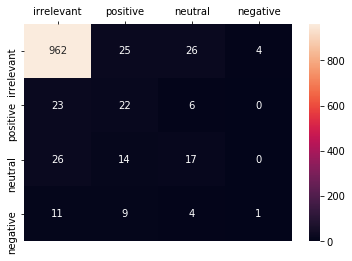

In [151]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_true, pred_cas_svm_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_true, pred_cas_svm_ir, average='micro')))
cm = confusion_matrix(valid_true, pred_cas_svm_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')

sentiment with BPEF

In [152]:
valid_dataset_X_cas_bpef = valid_dataset_X_cas.copy()
pred_cas_bpef_ir = pred_cas_svm_ir

In [153]:
for i in range(len(pred_cas_bpef_ir)):
    if pred_cas_bpef_ir[i] == 1:
        testo = valid_dataset_X_cas_bpef.iloc[i]['TESTO']
        quote = valid_dataset_X_cas_bpef.iloc[i]['(Testo Citato)']
        p = bpef.predict(pd.Series(testo), pd.Series(quote))
        pred_cas_bpef_ir[i] = p[0]

######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, '

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, '

######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, '

######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, '

######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, '

######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, '

######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, '

######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, 'rndfst') ########
######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, '

######## ('swnt', True, 'svm') ########
######## ('swnt', True, 'logreg') ########
######## ('swnt', True, 'naibay') ########
######## ('swnt', True, 'rndfst') ########
######## ('word', False, 'svm') ########
######## ('word', False, 'logreg') ########
######## ('word', False, 'naibay') ########
######## ('word', False, 'rndfst') ########
######## ('word', True, 'svm') ########
######## ('word', True, 'logreg') ########
######## ('word', True, 'naibay') ########
######## ('word', True, 'rndfst') ########
######## ('pos', False, 'svm') ########
######## ('pos', False, 'logreg') ########
######## ('pos', False, 'naibay') ########
######## ('pos', False, 'rndfst') ########
######## ('pos', True, 'svm') ########
######## ('pos', True, 'logreg') ########
######## ('pos', True, 'naibay') ########
######## ('pos', True, 'rndfst') ########
######## ('swnt', False, 'svm') ########
######## ('swnt', False, 'logreg') ########
######## ('swnt', False, 'naibay') ########
######## ('swnt', False, '

F1 macro score on validation data: 0.5527578007089378
F1 micro score on validation data: 0.8852173913043478


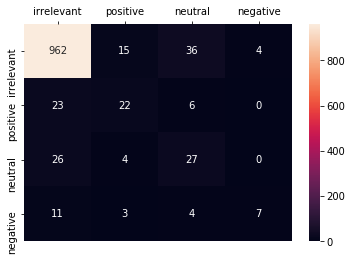

In [154]:
# 0=irrilevante, 1=positivo, 2=neutro, 3=negativo
print('F1 macro score on validation data: ' + str(f1_score(valid_true, pred_cas_bpef_ir, average='macro')))
print('F1 micro score on validation data: ' + str(f1_score(valid_true, pred_cas_bpef_ir, average='micro')))
cm = confusion_matrix(valid_true, pred_cas_bpef_ir, labels=[0, 1, 2, 3])
ax = sns.heatmap(cm, annot=True, xticklabels=['irrelevant','positive','neutral', 'negative'], yticklabels=['irrelevant','positive','neutral', 'negative'], fmt="d")
ax.xaxis.set_ticks_position('top')